# Lines
https://archaeologydataservice.ac.uk/archives/view/dob/ <br>
https://geoportal.statistics.gov.uk/<br>
https://osdatahub.os.uk/

In [1]:
# import libraries and set variables

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import fiona
import contextily as cx

shpLA="C:\dataGIS\ONS\LocalAuthorities\Local_Authority_Districts_(December_2020)_UK_BFC.shp"
oswater="C:\dataGIS\OS\Rivers\oprvrs_gb.gpkg"
osroads="C:\dataGIS\OS\Roads\oproad_gb.gpkg"
dob=r"C:\dataGIS\Defence\doc.kml"

s_title='Stop Line 14 - WW2 Defences on the Leeds and Liverpool Canal in West Lancs'
s_day='Brian Price #30DayMapChallenge 2021 Day 2 Lines'

s_code='Created using Python/Jupyter Notebook at github.com/bpmapper/bp21map30'
s_data='Data from Defence of Britain Archive © Council for British Archaeology (2006) https://doi.org/10.5284/1000327'
s_copy='Road and canal data from Ordnance Survey. Contains OS data © Crown copyright and database right 2021'
s_tiles='Map tiles by Stamen Design under CCBY3.0. Data by OpenStreetMap under ODbL'

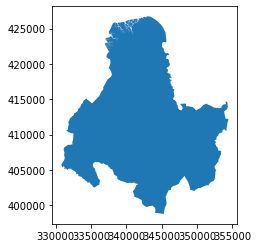

In [2]:
# Get LA shape

gdfLA=gpd.read_file(shpLA)
gdfLA=gdfLA[gdfLA.LAD20NM=='West Lancashire'].copy()
gdfLA.plot()

In [22]:
# See OS openrivers layers

for layername in fiona.listlayers(oswater):
    print(layername)

HydroNode
WatercourseLink


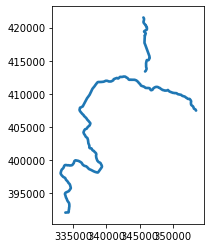

In [23]:
# Get Watercourse links in LA area and create canal buffer area

gdfWater=gpd.read_file(oswater, layer='WatercourseLink', mask=gdfLA)
gdfCanal=gdfWater[gdfWater.form=='canal']
gdfCanalBuff=gdfCanal.buffer(200)
gdfCanalBuff.plot()

In [24]:
# See Roads layers

for layername in fiona.listlayers(osroads):
    print(layername)

RoadLink
RoadNode
MotorwayJunction


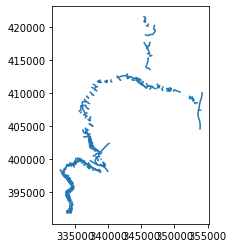

In [25]:
# Get roads in buffer area

gdfRoad=gpd.read_file(osroads, layer='RoadLink', mask=gdfCanalBuff)
gdfRoad.plot()

In [26]:
# Read in Defence Sites detail and locations and merge dataframes

dfD1=pd.read_xml(dob, xpath='//*[contains(name(),"LookAt")]')
dfD2=pd.read_xml(dob, xpath='//*[contains(name(),"Placemark")]')
dfDefences=dfD1.join(dfD2)
dfDefences.sample(3)

,longitude,latitude,altitude,range,tilt,heading,altitudeMode,name,visibility,description,LookAt,styleUrl,Point
536,-1.059226,54.603162,0,500.0,0.0,-0.031785,None,FLAME FOUGASSE: S0010748,0,<center><h1><u>The Defence of Britain</u></h1>...,NaN,#m_ylw-pushpin_copy07,NaN
6630,-0.477106,51.631414,0,500.0,0.0,-0.031785,None,PILLBOX (TYPE FW3/24): S0000536,0,<center><h1><u>The Defence of Britain</u></h1>...,NaN,#m_ylw-pushpin_copy07,NaN
9706,-4.693197,51.670921,0,500.0,0.0,-0.031785,None,GUN EMPLACEMENT: S0012217,0,<center><h1><u>The Defence of Britain</u></h1>...,NaN,#m_ylw-pushpin_copy07,NaN


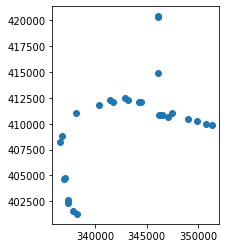

In [27]:
# Convert to geodataframe and clip to buffered canal area 

gdfDefences=gpd.GeoDataFrame(dfDefences,
                            geometry=gpd.points_from_xy(dfDefences.longitude, dfDefences.latitude),
                            crs="epsg:4326")
gdfDefences=gdfDefences.to_crs("epsg:27700")
gdfDefences=gdfDefences.clip(gdfCanalBuff)
gdfDefences.plot()

In [28]:
# site names

gdfDefences.name[:5]

3777                  PILLBOX: S0011743
3776                  PILLBOX: S0011742
314            LOOPHOLED WALL: S0011741
6049    PILLBOX (TYPE FW3/22): S0011740
7980    PILLBOX (TYPE FW3/24): S0011738
Name: name, dtype: object

In [29]:
# Classify defence site types

def defencetype(s):
    res="OTH"
    if "DEFENDED" in str(s):
        res = "DEF"
    elif "PILLB" in str(s):
        res= "PIL"
    return res

gdfDefences['deftype']=gdfDefences.name.apply(defencetype)

In [30]:
# convert dataframes to WGS84

gdfRoad=gdfRoad.to_crs('epsg:3857')
gdfDefences=gdfDefences.to_crs('epsg:3857')
gdfCanal=gdfCanal.to_crs('epsg:3857')
gdfCanalBuff=gdfCanalBuff.to_crs('epsg:3857')


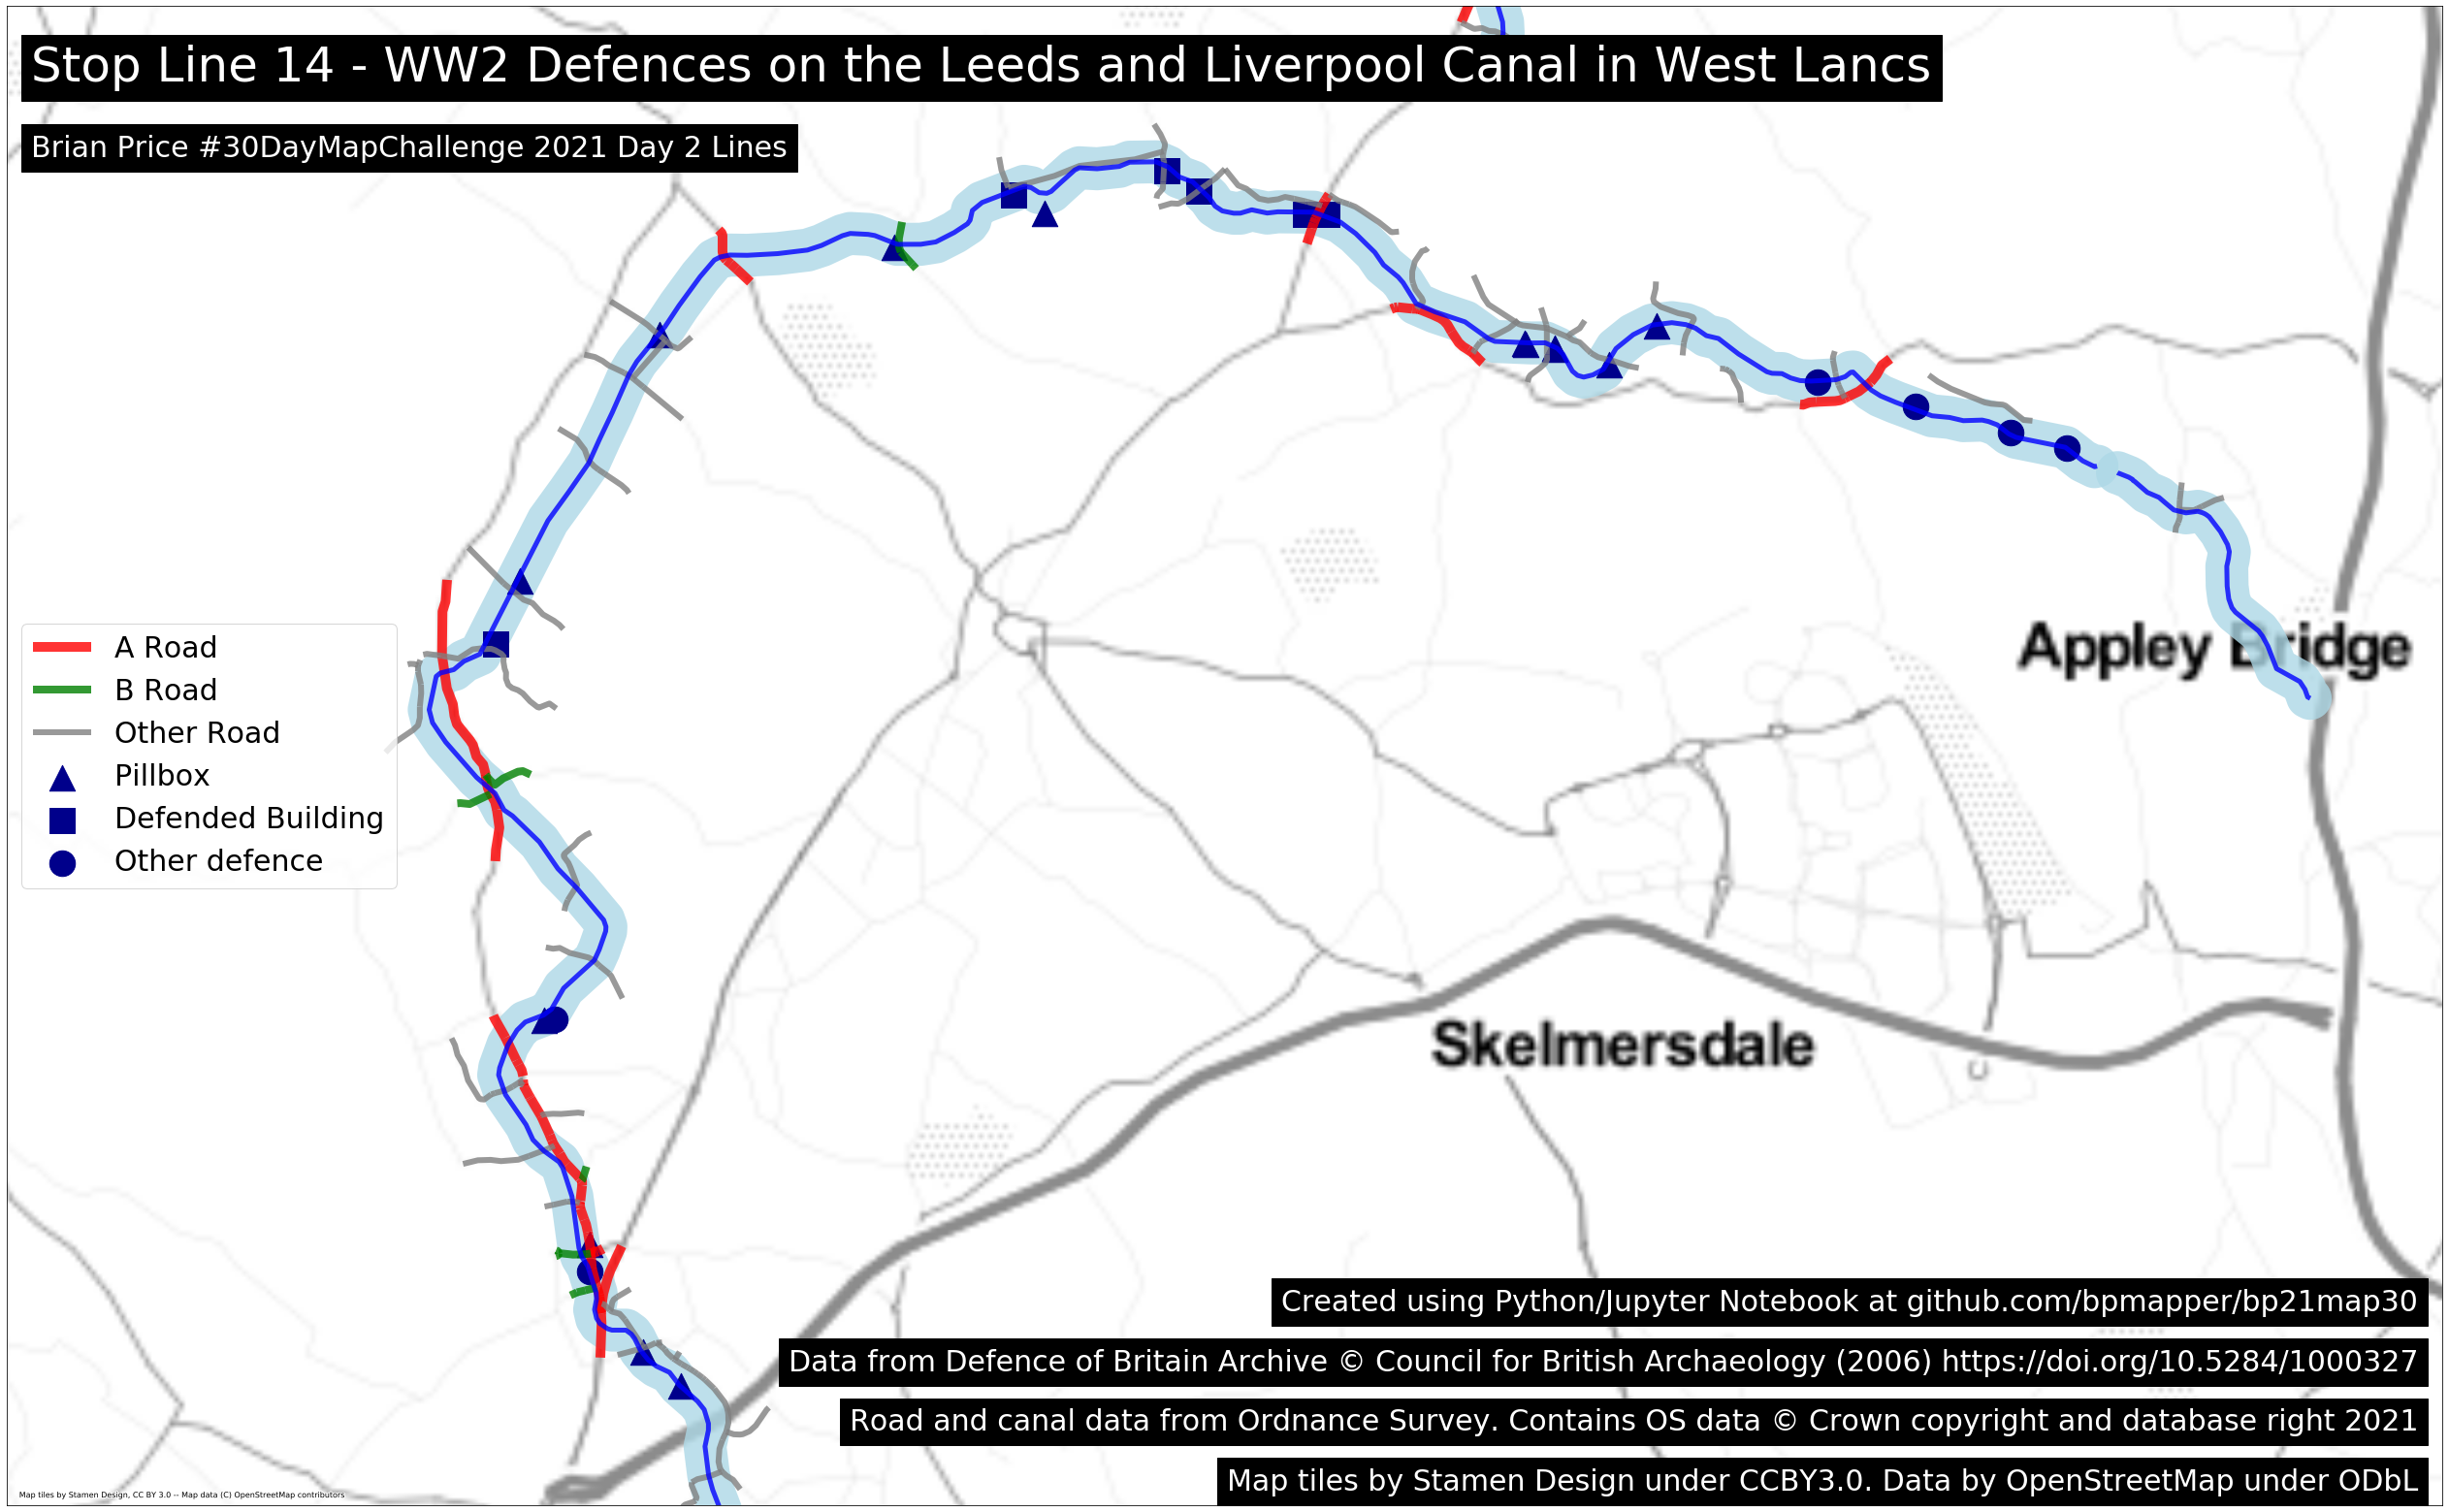

In [31]:
# plot

fig, ax = plt.subplots(figsize=(45,50))

gdfRoad[gdfRoad.roadFunction==("A Road")].plot(ax=ax, color='red',alpha=.8, linewidth=10, label="A Road")
gdfRoad[gdfRoad.roadFunction==("B Road")].plot(ax=ax, color='green',alpha=.8, linewidth=8, label="B Road")
gdfRoad[gdfRoad.roadFunction==("Minor Road")].plot(ax=ax, color='grey',alpha=.8, linewidth=6, label="Other Road")

gdfCanal.plot(ax=ax, color='blue', alpha=0.8, linewidth=5)
gdfCanalBuff.plot(ax=ax, color='lightblue', alpha=0.8)

gdfDefences[gdfDefences.deftype=='PIL'].plot(ax=ax, color='darkblue', markersize=700, marker='^', label='Pillbox')
gdfDefences[gdfDefences.deftype=='DEF'].plot(ax=ax, color='darkblue', markersize=700, marker='s', label='Defended Building')
gdfDefences[gdfDefences.deftype=='OTH'].plot(ax=ax, color='darkblue', markersize=700, marker='o', label='Other defence')

cx.add_basemap(ax=ax, source=cx.providers.Stamen.TonerLite, zoom=11)

ax.set_ylim([7075000, 7098500])
plt.tick_params(axis='both',which='both',bottom=False,left=False,labelbottom=False,labelleft=False)

ax.text(.01, .95, s_title,transform=ax.transAxes, fontsize=50,
        bbox={'facecolor': 'black', 'alpha': 1, 'pad': 10}).set_color('white')
ax.text(.01, .90, s_day,transform=ax.transAxes, fontsize=30,
        bbox={'facecolor': 'black', 'alpha': 1, 'pad': 10}).set_color('white')
ax.text(.99, .13, s_code,transform=ax.transAxes, fontsize=30, horizontalalignment='right',
        bbox={'facecolor': 'black', 'alpha': 1, 'pad': 10}).set_color('white')
ax.text(.99, .09, s_data,transform=ax.transAxes, fontsize=30, horizontalalignment='right',
        bbox={'facecolor': 'black', 'alpha': 1, 'pad': 10}).set_color('white')
ax.text(.99, .05, s_copy,transform=ax.transAxes, fontsize=30, horizontalalignment='right',
        bbox={'facecolor': 'black', 'alpha': 1, 'pad': 10}).set_color('white')
ax.text(.99, .01, s_tiles,transform=ax.transAxes, fontsize=30, horizontalalignment='right',
        bbox={'facecolor': 'black', 'alpha': 1, 'pad': 10}).set_color('white')
ax.legend()
plt.legend(fontsize=30, loc='center left' )
plt.show()


fig.savefig('Day02_Lines_StopLine14.png')